In [3]:
# written to merge networks from drugs
# associated with the same DMEs
# re-written 9-18-19, JLW

import pickle,os,csv,itertools,functools, random, math
import networkx as nx
from collections import defaultdict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from networkx.drawing.nx_agraph import graphviz_layout, to_agraph

rscs_dir = '../rscs/'
data_dir = '../data/'
dme_mdir = os.path.join(data_dir,'dme_merged_data')
ctdir = os.path.join(data_dir,'cotherapy')

dd_dic = functools.partial(defaultdict, dict)

true_positives_dbid = pickle.load(open(os.path.join(data_dir,'true_positives_dbid.pkl'),'rb'))
dintf = os.path.join(rscs_dir,'drug_intome_targets.pkl')
dint = pickle.load(open(dintf,'rb')) # to find number of drug targets

db2nf = os.path.join(rscs_dir,'drugbankid_to_name.pkl')
db2n = pickle.load(open(db2nf,'rb'))

dme_net_f = {}
dme_net_data = {}
for dme in true_positives_dbid:
    dme_lookup = dme.replace(' ','_')
    dme_net_f[dme] = os.path.join(dme_mdir,dme_lookup+'_merged_net.pkl')
    dme_net_data[dme] = os.path.join(dme_mdir,dme_lookup+'_zipped_net_data.pkl')
#print([k for k in true_positives_dbid.keys()])


In [4]:
def pairwise(iterable):
    a,b = itertools.tee(iterable)
    next(b,None)
    return zip(a,b)

In [5]:
def create_layer_array(layer_num,nrows,min_positions,fig_width):
    # for phenotype layer, reduce the number of rows
    if layer_num == 1:
        nrows = 2
        ymin = 0.5
        ymax = 1.0
    elif layer_num == 2:
        ymin = 1.3
        ymax = 3.3
    elif layer_num == 3:
        ymin = 3.6
        ymax = 8.6
    else:
        ymin = 8.9 #layer_num*2 - 1.0
        ymax = 14.9 #layer_num*2 + 1.0
    
    min_cols = math.ceil(float(min_positions)/nrows)
    act_cols = min_cols *2
    layer_arr = []
    for x1 in np.linspace(0,fig_width,act_cols):
        for y1 in np.linspace(ymin,ymax,nrows):
            layer_arr.append((x1,y1))
    return layer_arr

In [6]:
def assign_layer_positions(layer_arr,node_list):
    layer_pos = {}
    for n in node_list:
        rand_ind = np.random.choice(range(len(layer_arr)))
        (xd,yd) = layer_arr[rand_ind]
        layer_pos[n] = (xd,yd)
        layer_arr.remove((xd,yd))
    return layer_pos

In [7]:
def get_layered_positions(ntd,nrows,fig_width):
    all_pos = {}
    drugs = [n for (n,nt) in ntd.items() if nt == 'drug']
    num_drugs = len(drugs)
    drug_layer = create_layer_array(4,nrows,num_drugs,fig_width)
    drug_pos = assign_layer_positions(drug_layer,drugs)
    all_pos.update(drug_pos)
    
    drug_targets = [n for (n,nt) in ntd.items() if nt == 'drug_target']
    num_dts = len(drug_targets)
    dt_layer = create_layer_array(3,nrows,num_dts,fig_width)
    dt_pos = assign_layer_positions(dt_layer,drug_targets)
    all_pos.update(dt_pos)
  
    intermed = [n for (n,nt) in ntd.items() if nt == 'intermediate']
    num_inter = len(intermed)
    inter_layer = create_layer_array(2,nrows,num_inter,fig_width)
    inter_pos = assign_layer_positions(inter_layer,intermed)
    all_pos.update(inter_pos)
    
    phenotypes = [n for (n,nt) in ntd.items() if nt == 'phenotype']
    num_ph = len(phenotypes)
    ph_layer = create_layer_array(1,nrows,num_ph,fig_width)
    ph_pos = assign_layer_positions(ph_layer,phenotypes)
    all_pos.update(ph_pos)

    return all_pos

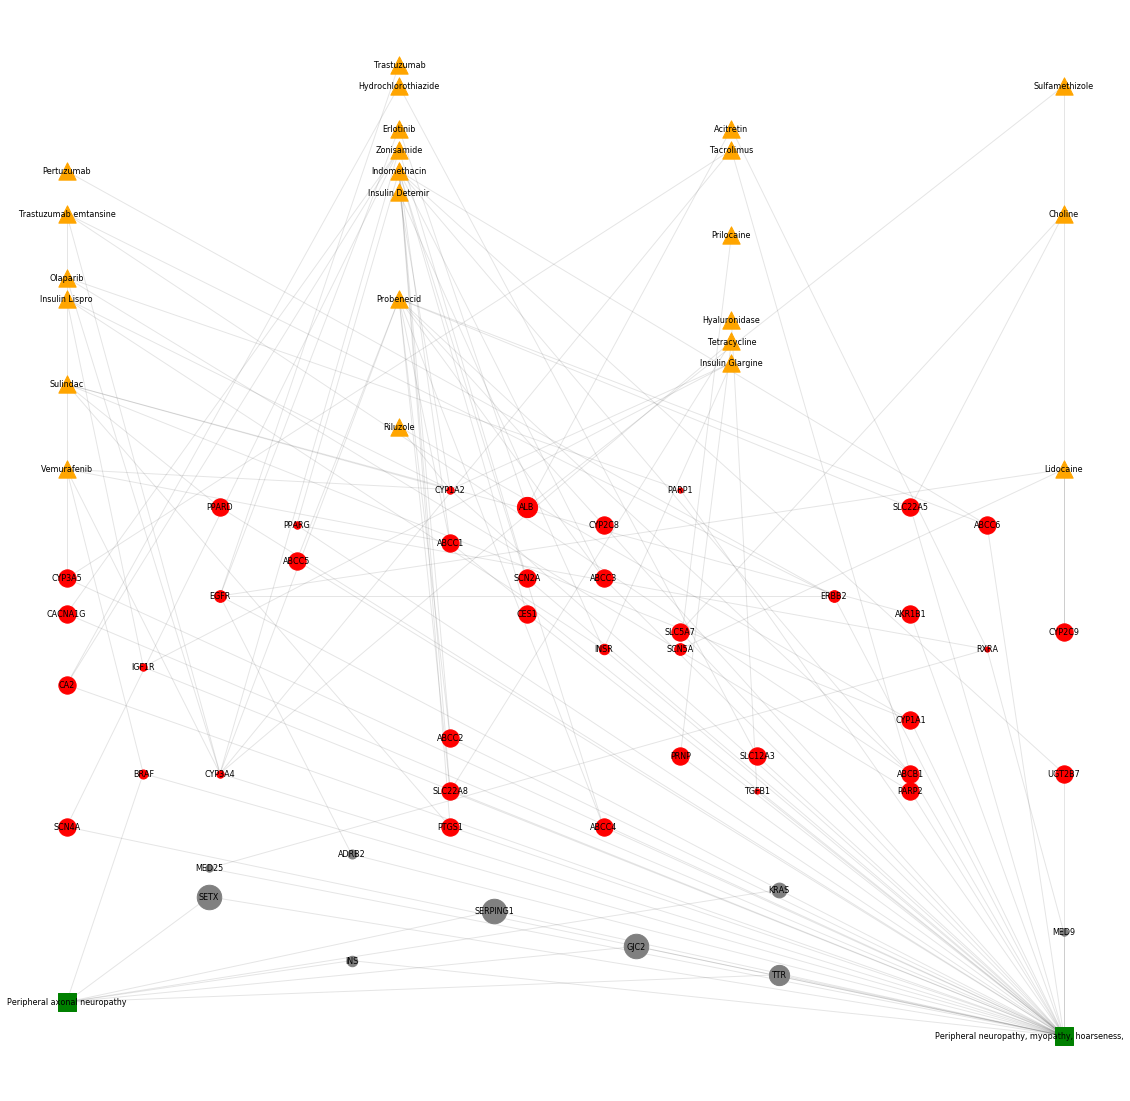

In [9]:
#gene_of_interest = 'MTNR1A'
#dme = 'Tardive dyskinesia'
#gene_of_interest = 'TP53'
#dme = 'Gastric ulcer'
#gene_of_interest = 'F2'
#dme = 'Myocardial Infarction'
gene_of_interest = 'ADRB2'
dme = 'Peripheral neuropathy'
    
# dme_lookup = dme.replace(' ','_')
dmeG = pickle.load(open(dme_net_f[dme],'rb'))
net_data = pickle.load(open(dme_net_data[dme],'rb')) # zipped object:(node_list,colors,shapes,sizes,graph_node_types)
stash_data = [x for x in net_data]
node_data = defaultdict(dict)
dme_drugs = set()
dme_phens = set()

# store data that's useful for plotting
node_just_type = {}
for (n,clr,shp,sze,nt) in stash_data:
    node_data[n]['color'] = clr
    node_data[n]['shape'] = shp
    node_data[n]['size'] = sze
    node_data[n]['node_type'] = nt
    node_just_type[n] = nt
    if nt == 'drug':
        dme_drugs.add(n)
    elif nt == 'phenotype':
        dme_phens.add(n)

# loop through paths and look for gene of interest
edges_to_keep = set()
nodes_to_keep = set()
for drug in dme_drugs:
    for ph in dme_phens:
        if nx.has_path(dmeG,drug,ph):
            #aspths = [p for p in nx.all_shortest_paths(dmeG,source=drug,target=ph)] # keep a subset of edges from drugs -> phen
            #for short_pth in aspths:
            #    ind_edges = pairwise(short_pth)
            #    for (a,b) in ind_edges:
            #        edges_to_keep.add((a,b))
            #        nodes_to_keep.add(a)
            #        nodes_to_keep.add(b)
            aspths2 = [p for p in nx.all_shortest_paths(dmeG,source=drug,target=gene_of_interest)] # look specifically for relation to gene of interest
            for short_pth in aspths2:
                ind_edges = pairwise(short_pth)
                for (a,b) in ind_edges:
                    edges_to_keep.add((a,b))
                    nodes_to_keep.add(a)
                    nodes_to_keep.add(b)
    
            aspths3 = [p for p in nx.all_shortest_paths(dmeG,source=gene_of_interest,target=ph)] # lastly edges from GOI to ph
            for short_pth in aspths3:
                ind_edges = pairwise(short_pth)
                for (a,b) in ind_edges:
                    edges_to_keep.add((a,b))
                    nodes_to_keep.add(a)
                    nodes_to_keep.add(b)

# specifications for figure making
fig_width = 10
nrows = 20

pos = get_layered_positions(node_just_type,nrows,fig_width)
                
fig,ax = plt.subplots(figsize=(20,20))
#ax.set_ylim([0,fig_height])
#ax.set_xlim([0,fig_width])
dmeG = nx.Graph()
for (a,b) in edges_to_keep:
    dmeG.add_edge(a,b)

ec = nx.draw_networkx_edges(dmeG, pos, alpha=0.1)
# ec = nx.draw_networkx_edges(dmeG,positions,alpha=0.2)

for n in dmeG.nodes():
    nc = nx.draw_networkx_nodes(dmeG,pos,nodelist=[n],node_color=node_data[n]['color'],node_shape=node_data[n]['shape'],node_size=node_data[n]['size'])
    nc = nx.draw_networkx_labels(dmeG,pos,labels={n:n},font_size = 8, weight='bold')
    
plt.axis('off')
plt.savefig(os.path.join(ctdir,'_'.join([dme,gene_of_interest,'network','.png'])),dpi=300)
plt.show()   

In [ ]:
### OLD CODE FOR DEVELOPMENT
# generate positions for certain node types
layers = 4
all_drugs = sorted([n for (n,clr,shp,sze,nt) in stash_data if nt == 'drug'])
num_drugs = len(all_drugs)
layer1 = []
lay1_col = math.ceil(num_drugs/float(layers))
for yi in np.linspace(0.95*fig_height,1.25*fig_height,layers):
    for xi in np.linspace(0,fig_width,lay1_col):
        layer1.append((xi,yi))

random.shuffle(layer1)
drug_positions = dict(zip(all_drugs,layer1))     

all_drug_targets = sorted([n for (n,clr,shp,sze,nt) in stash_data if nt == 'drug_target' and n in nodes_to_keep])
num_drug_targets = len(all_drug_targets)
layer2 = []
lay2_col = math.ceil(num_drug_targets/float(layers))
for yi in np.linspace(0.625*fig_height,0.825*fig_height,layers):
    for xi in np.linspace(0,fig_width,lay2_col):
        layer2.append((xi,yi))

random.shuffle(layer2)
dt_positions = dict(zip(all_drug_targets,layer2))

all_inter = sorted([n for (n,clr,shp,sze,nt) in stash_data if nt == 'intermediate' and n in nodes_to_keep])
num_inter = len(all_inter)
col = math.ceil(num_inter/float(layers))
layer3 = []
for yi in np.linspace(0.25*fig_height,0.55*fig_height,layers):
    for xi in np.linspace(0,fig_width,col):
        layer3.append((xi,yi))
        
random.shuffle(layer3)
int_positions = dict(zip(all_inter,layer3))

all_phens = sorted([n for (n,clr,shp,sze,nt) in stash_data if nt == 'phenotype'])
num_phen = len(all_phens)
phen_sep = fig_width/float(num_phen)
ph_positions = dict([(ph,(0.5,ph_i*phen_sep)) for (ph_i,ph) in enumerate(all_phens)])

positions = {**drug_positions, **dt_positions, **int_positions, **ph_positions}